# NPM Kompleks Ağ Analizi (Top N)

Bu defter, popüler Top N NPM paketini yönlü bir ağ (Dependent → Dependency) olarak modelleyip, in-degree / out-degree / betweenness merkeziyet metrikleriyle yapısal riski inceler.

Amaç:
- Bağımlılık ağındaki konuma dayalı kritik düğümleri belirlemek
- Zincirleme etki potansiyelini (cascading impact) nicel olarak görmek
- Sonuçları tekrar üretilebilir şekilde görselleştirmek ve raporlamak

Metodoloji (özet):
- Veri: Liste her çalıştırmada API’lerden çekilir (ecosyste.ms / npm registry / npms.io yedekli)
- Ağ: NetworkX DiGraph (kenar: Dependent → Dependency)
- Metrikler: In-Degree (gelen), Out-Degree (giden), Betweenness
- Performans: Büyük graf’larda betweenness için örneklemeli hesap
- Çıktılar: Tüm sonuçlar `results/` klasörüne yazılır (CSV/MD/JSON + PNG/SVG)

Varsayılan Top N = 1000 (değiştirilebilir).

## 1) İçe Aktarım ve Parametreler

Yardımcı fonksiyonlar `analysis_helpers.py` içindedir. Varsayılan `OUTDIR` = `results/`.

In [ ]:
# İçe aktarımlar ve temel parametreler
from pathlib import Path
import sys
import os

# Matplotlib kontrol/kurulum (gerekirse)
try:
    import matplotlib  # noqa: F401
    import matplotlib.pyplot as plt  # noqa: F401
    print('matplotlib hazır')
except ModuleNotFoundError:
    import subprocess
    print('matplotlib eksik; kuruluyor...')
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'matplotlib'])
    import matplotlib  # noqa: F401
    import matplotlib.pyplot as plt  # noqa: F401
    print('kurulum tamam')

import networkx as nx
from analysis_helpers import (
    fetch_top_packages,
    build_dependency_graph,
    compute_metrics,
    save_edges,
    save_metrics,
    save_report,
    read_list,
)

TOP_N = 1000  # Top N paket (varsayılan)
OUTDIR = Path('results')
OUTDIR.mkdir(parents=True, exist_ok=True)
OUTDIR


## 2) Top N Paketleri Yükle

Liste her çalıştırmada API’lerden çekilir (indirme sayısına göre sıralı).

In [42]:
top_packages = fetch_top_packages(TOP_N)
print(f'API’lerden {len(top_packages)} paket çekildi')
len(top_packages), top_packages[:20]

API’lerden 1000 paket çekildi


(1000,
 ['semver',
  'ansi-styles',
  'debug',
  'chalk',
  'minimatch',
  'supports-color',
  'strip-ansi',
  'ms',
  'ansi-regex',
  'tslib',
  'string-width',
  'brace-expansion',
  'lru-cache',
  'commander',
  'type-fest',
  'wrap-ansi',
  'glob',
  'emoji-regex',
  'color-convert',
  'source-map'])

## 3) Yönlü Ağı Kur

Düğümler paketler; kenarlar Dependent → Dependency. Varsayılan olarak yalnızca `dependencies` kullanılır.

In [43]:
G, top_set = build_dependency_graph(top_packages)
G.number_of_nodes(), G.number_of_edges()

(1139, 2164)

## 4) Merkeziyet Metrikleri

- In-Degree: Düğüme gelen kenar → etkilenebilecek alan

- Out-Degree: Düğümün dış bağımlılık sayısı → bağımlılık zinciri uzunluğu

- Betweenness: En kısa yollardaki aracılık → tek hata noktası riski



Not: Büyük graf’larda betweenness yaklaşık örnekleme (k) ile hızlandırılır.

In [44]:
in_deg, out_deg, btw = compute_metrics(G)
nodes = G.number_of_nodes(); edges = G.number_of_edges()
nodes, edges

(1139, 2164)

## 5) Liderler: İlk 10 (Özet + Görselleştirme)
Bu adımda in-degree / out-degree / betweenness için ilk 10’u hem metin olarak özetler hem de bar grafikleri PNG+SVG olarak results/ klasörüne kaydeder.

In [45]:
top_in_all = sorted(in_deg.items(), key=lambda kv: kv[1], reverse=True)[:10]
top_btw_all = sorted(btw.items(), key=lambda kv: kv[1], reverse=True)[:10]
top_in_top = sorted(((n, in_deg.get(n, 0)) for n in top_set), key=lambda kv: kv[1], reverse=True)[:10]
top_btw_top = sorted(((n, btw.get(n, 0.0)) for n in top_set), key=lambda kv: kv[1], reverse=True)[:10]
top_in_all, top_btw_all, top_in_top, top_btw_top

([('tslib', 62),
  ('@babel/helper-plugin-utils', 58),
  ('@smithy/types', 48),
  ('call-bound', 38),
  ('es-errors', 28),
  ('call-bind', 24),
  ('chalk', 23),
  ('@types/node', 23),
  ('@jest/types', 23),
  ('debug', 21)],
 [('es-abstract', 0.0007853248581506152),
  ('jest-snapshot', 0.0005318972166447949),
  ('@jest/transform', 0.000419395484164486),
  ('get-intrinsic', 0.00032806916867761756),
  ('@babel/core', 0.0003244954940054893),
  ('glob', 0.0003006400774090235),
  ('@babel/traverse', 0.0002804796374035562),
  ('babel-plugin-istanbul', 0.00026019406870875217),
  ('@jest/core', 0.00023789724034564076),
  ('reflect.getprototypeof', 0.00021073143386510817)],
 [('tslib', 62),
  ('@babel/helper-plugin-utils', 58),
  ('@smithy/types', 48),
  ('call-bound', 38),
  ('es-errors', 28),
  ('call-bind', 24),
  ('chalk', 23),
  ('@jest/types', 23),
  ('@types/node', 23),
  ('debug', 21)],
 [('es-abstract', 0.0007853248581506152),
  ('jest-snapshot', 0.0005318972166447949),
  ('@jest/trans

## 6) Sonuçları Kaydet

Kenarlar, metrikler ve kısa rapor `results/` altına yazılır.

In [46]:
save_edges(G, OUTDIR / 'edges.csv')
save_metrics(in_deg, out_deg, btw, top_set, OUTDIR / 'metrics.csv')
save_report(in_deg, out_deg, btw, top_set, OUTDIR / 'report.md')
(OUTDIR / 'top_packages.txt').write_text(os.linesep.join(top_packages), encoding='utf-8')
sorted(OUTDIR.iterdir())

[WindowsPath('results/degree_histograms.png'),
 WindowsPath('results/degree_histograms.svg'),
 WindowsPath('results/edge_betweenness_top10.csv'),
 WindowsPath('results/edges.csv'),
 WindowsPath('results/graph_stats.json'),
 WindowsPath('results/metrics.csv'),
 WindowsPath('results/network_full_topN.png'),
 WindowsPath('results/network_full_topN.svg'),
 WindowsPath('results/network_topN_only.png'),
 WindowsPath('results/network_topN_only.svg'),
 WindowsPath('results/report.md'),
 WindowsPath('results/scatter_correlations.png'),
 WindowsPath('results/scatter_correlations.svg'),
 WindowsPath('results/top10_betweenness.png'),
 WindowsPath('results/top10_betweenness.svg'),
 WindowsPath('results/top10_in_degree.png'),
 WindowsPath('results/top10_in_degree.svg'),
 WindowsPath('results/top10_leaders.png'),
 WindowsPath('results/top10_leaders.svg'),
 WindowsPath('results/top10_out_degree.png'),
 WindowsPath('results/top10_out_degree.svg'),
 WindowsPath('results/top_packages.txt')]

## 7) Hızlı Doğrulama

Rastgele bazı paketler için registry’deki `dependencies` ile graf kenarlarını karşılaştıralım. Küçük farklar sürüm farklılıklarından kaynaklanabilir.

In [47]:
import random, requests, urllib.parse
def get_registry_deps(name: str):
    url = f'https://registry.npmjs.org/{urllib.parse.quote(name, safe="")}'
    r = requests.get(url, timeout=30)
    if r.status_code != 200:
        return {}
    data = r.json()
    latest = (data.get('dist-tags') or {}).get('latest')
    versions = data.get('versions') or {}
    obj = versions.get(latest) if latest in versions else {}
    return obj.get('dependencies') or {}

sample = random.sample(top_packages, k=min(5, len(top_packages)))
mismatches = {}
for pkg in sample:
    deps_live = set(get_registry_deps(pkg).keys())
    deps_graph = set(v for u,v in G.out_edges(pkg))
    if deps_live != deps_graph:
        mismatches[pkg] = {
            'live_only': sorted(list(deps_live - deps_graph)),
            'graph_only': sorted(list(deps_graph - deps_live)),
        }
mismatches

{}

## 8) Tüm Ağ Çizimi (Top N + Bağımlılıklar)

Top N düğümleri turuncu, diğerleri mavi; düğüm boyutu in-degree ile ölçeklenir.

In [48]:
import math
try:
    import matplotlib.pyplot as plt
    N = G.number_of_nodes()
    pos = nx.spring_layout(G, k=1/math.sqrt(max(N,1)), seed=42)
    max_in = max(in_deg.values()) if in_deg else 1
    node_sizes = [100 + (400 * (in_deg.get(n,0) / max_in if max_in else 0)) for n in G.nodes()]
    node_colors = ['tab:orange' if n in top_set else 'tab:blue' for n in G.nodes()]
    plt.figure(figsize=(12, 9), dpi=150)
    nx.draw_networkx_edges(G, pos, arrows=False, width=0.5, alpha=0.25)
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, alpha=0.85, linewidths=0.2, edgecolors='#444444')
    plt.title('NPM Top N Bağımlılık Ağı (Tümü)')
    plt.axis('off')
    out_png = OUTDIR / 'network_full_topN.png'
    out_svg = OUTDIR / 'network_full_topN.svg'
    plt.tight_layout(); plt.savefig(out_png); plt.savefig(out_svg)
    (out_png, out_svg)
except ModuleNotFoundError:
    print('matplotlib bulunamadı; görselleştirme atlandı.')


matplotlib bulunamadı; görselleştirme atlandı.


## 9) Sadece Top N (İndüklenmiş Alt-Ağ)

Sadece Top N düğümleri; düğüm sayısı azsa etiketleri göster.

In [49]:
try:
    H = G.subgraph(top_set).copy()
    HN = H.number_of_nodes() or 1
    posH = nx.spring_layout(H, k=1/math.sqrt(HN), seed=42)
    max_in_H = max((in_deg.get(n,0) for n in H.nodes()), default=1)
    node_sizes_H = [120 + (480 * (in_deg.get(n,0) / max_in_H if max_in_H else 0)) for n in H.nodes()]
    node_colors_H = ['tab:orange' for _ in H.nodes()]
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 8), dpi=150)
    nx.draw_networkx_edges(H, posH, arrows=False, width=0.6, alpha=0.35)
    nx.draw_networkx_nodes(H, posH, node_size=node_sizes_H, node_color=node_colors_H, alpha=0.9, linewidths=0.2, edgecolors='#444444')
    if H.number_of_nodes() <= 60:
        nx.draw_networkx_labels(H, posH, font_size=6)
    plt.title('NPM Top N Bağımlılık Ağı (Sadece Top N)')
    plt.axis('off')
    out_png2 = OUTDIR / 'network_topN_only.png'
    out_svg2 = OUTDIR / 'network_topN_only.svg'
    plt.tight_layout(); plt.savefig(out_png2); plt.savefig(out_svg2)
    (out_png2, out_svg2)
except ModuleNotFoundError:
    print('matplotlib bulunamadı; görselleştirme atlandı.')


matplotlib bulunamadı; görselleştirme atlandı.


## 14) Varsayımlar ve Sınırlamalar

- Kenar yönü Dependent → Dependency; yayılım analizi için uygundur.

- Varsayılan olarak yalnızca `dependencies` dahil; `peerDependencies` talebe göre eklenebilir.

- Küresel dependent sayıları dahil değildir; ecosyste.ms’ten eklenebilir.

- En güncel sürüm kullanılır; eski sürümlerde bağımlılıklar farklı olabilir.

results\top10_leaders.png


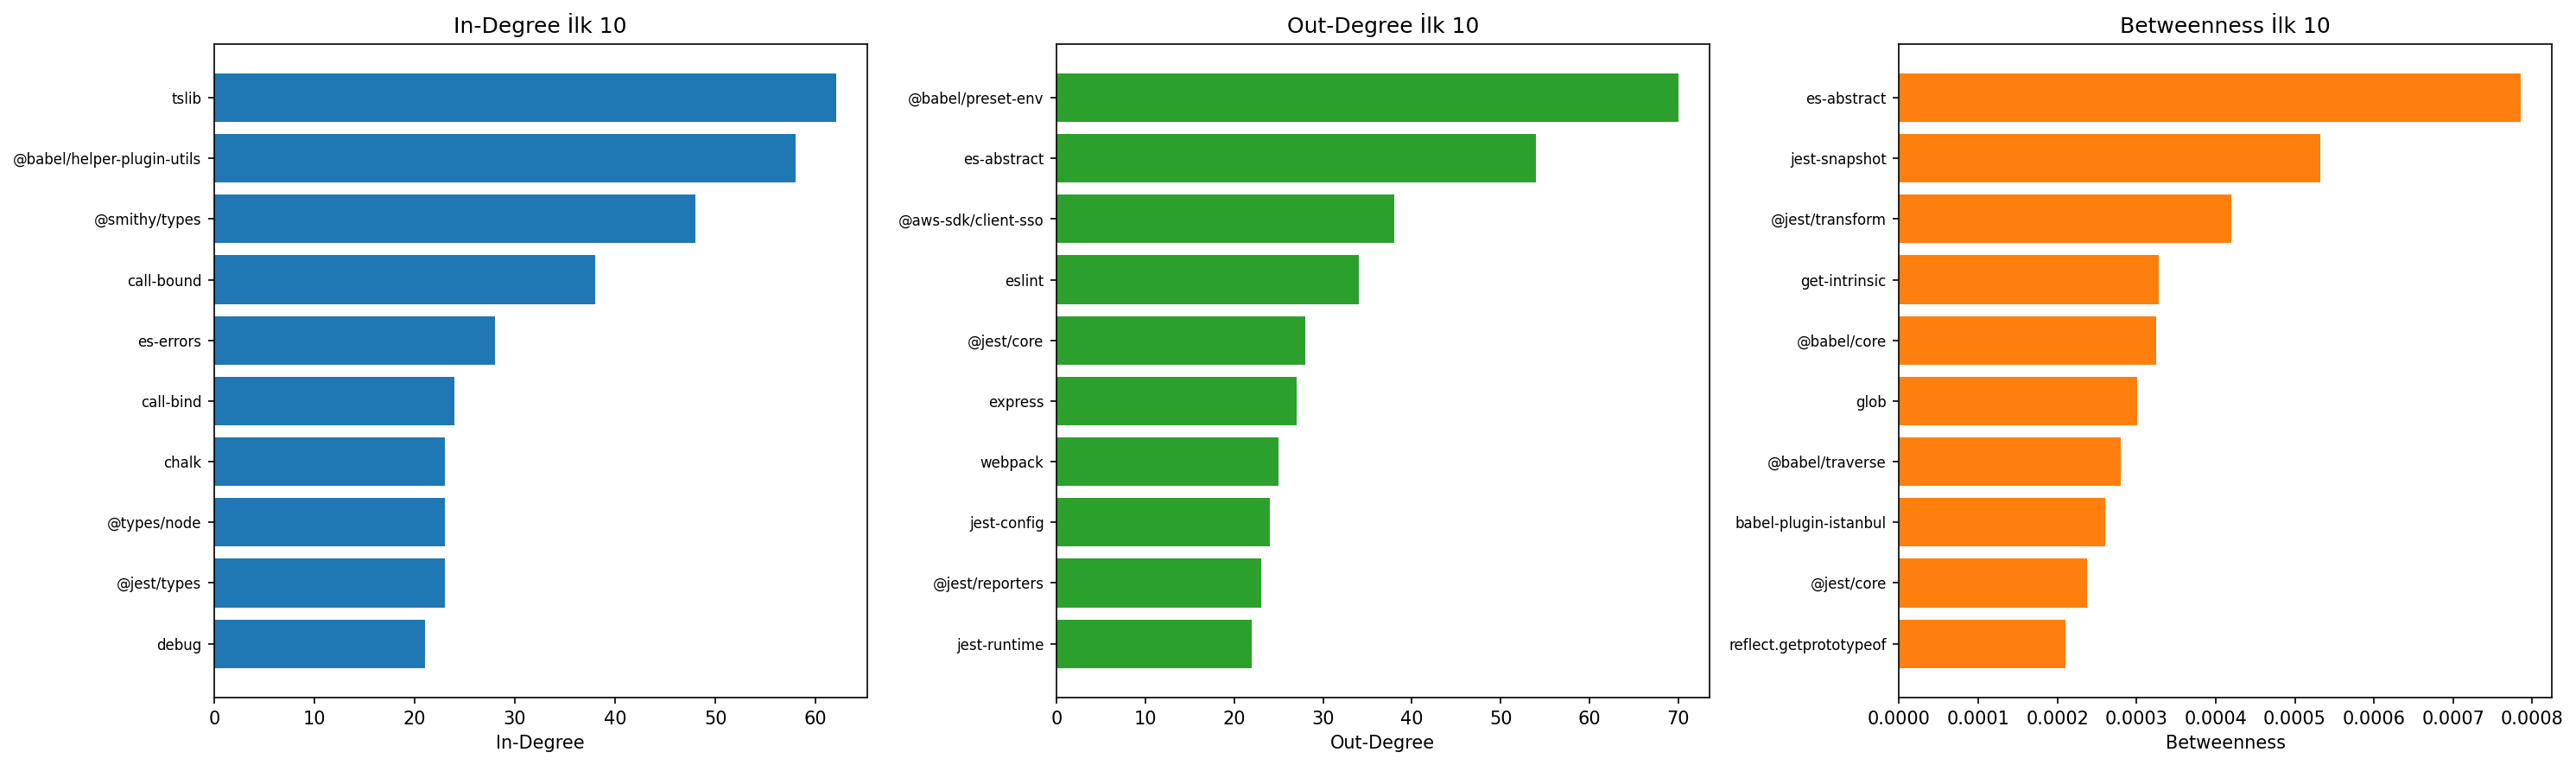

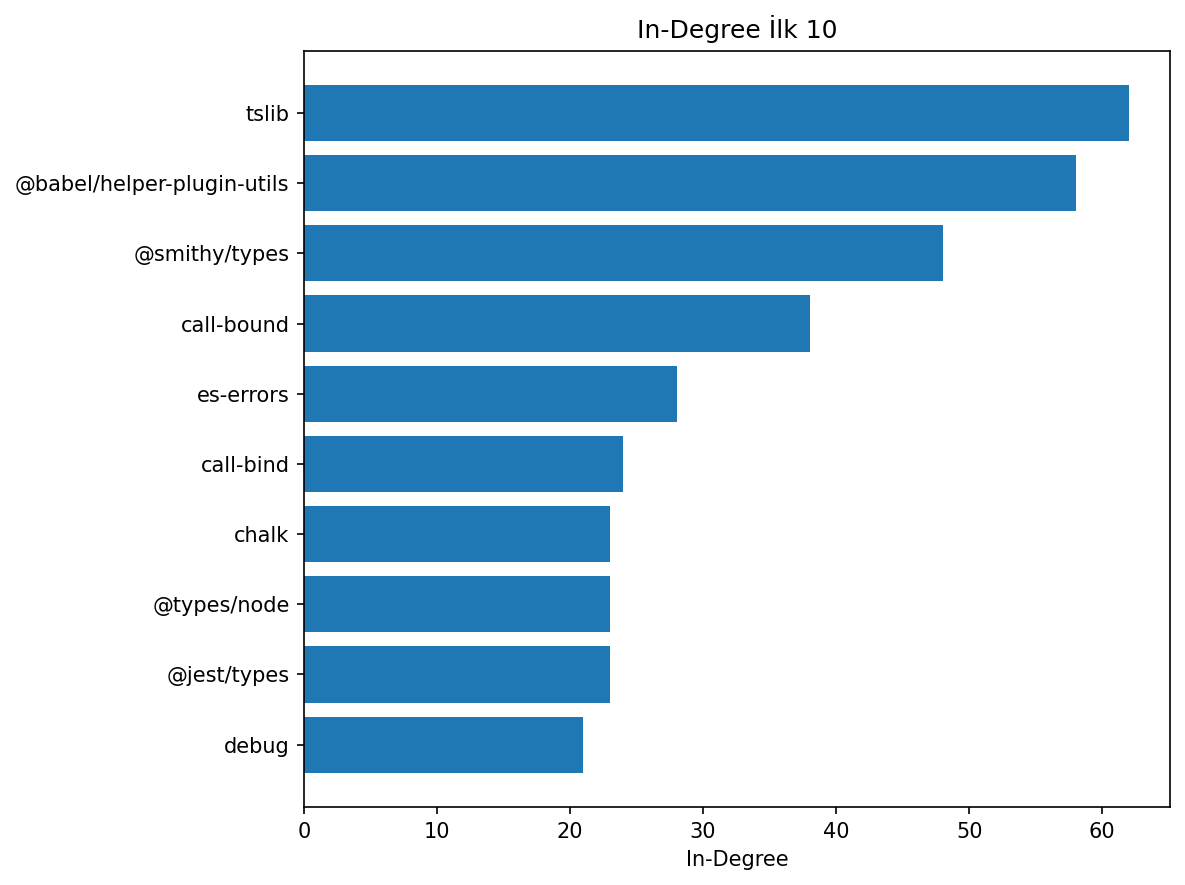

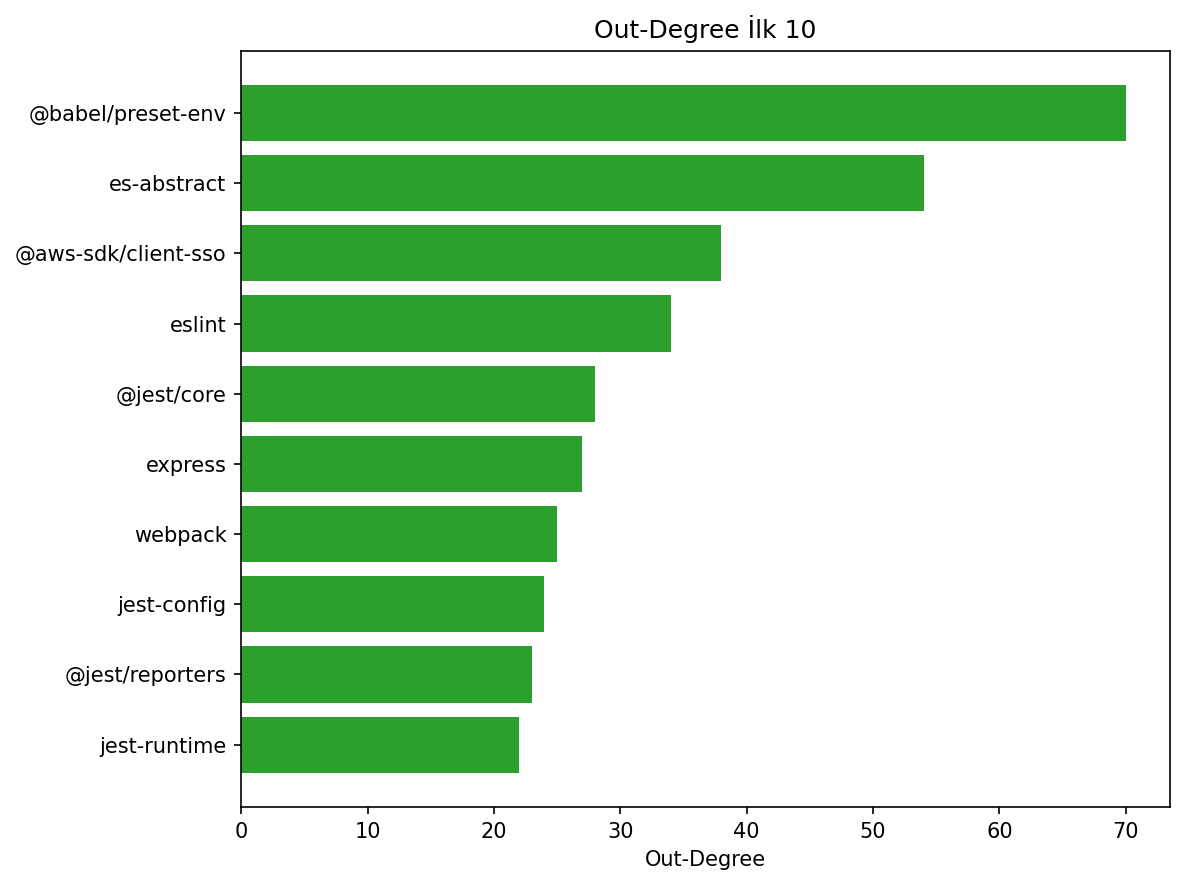

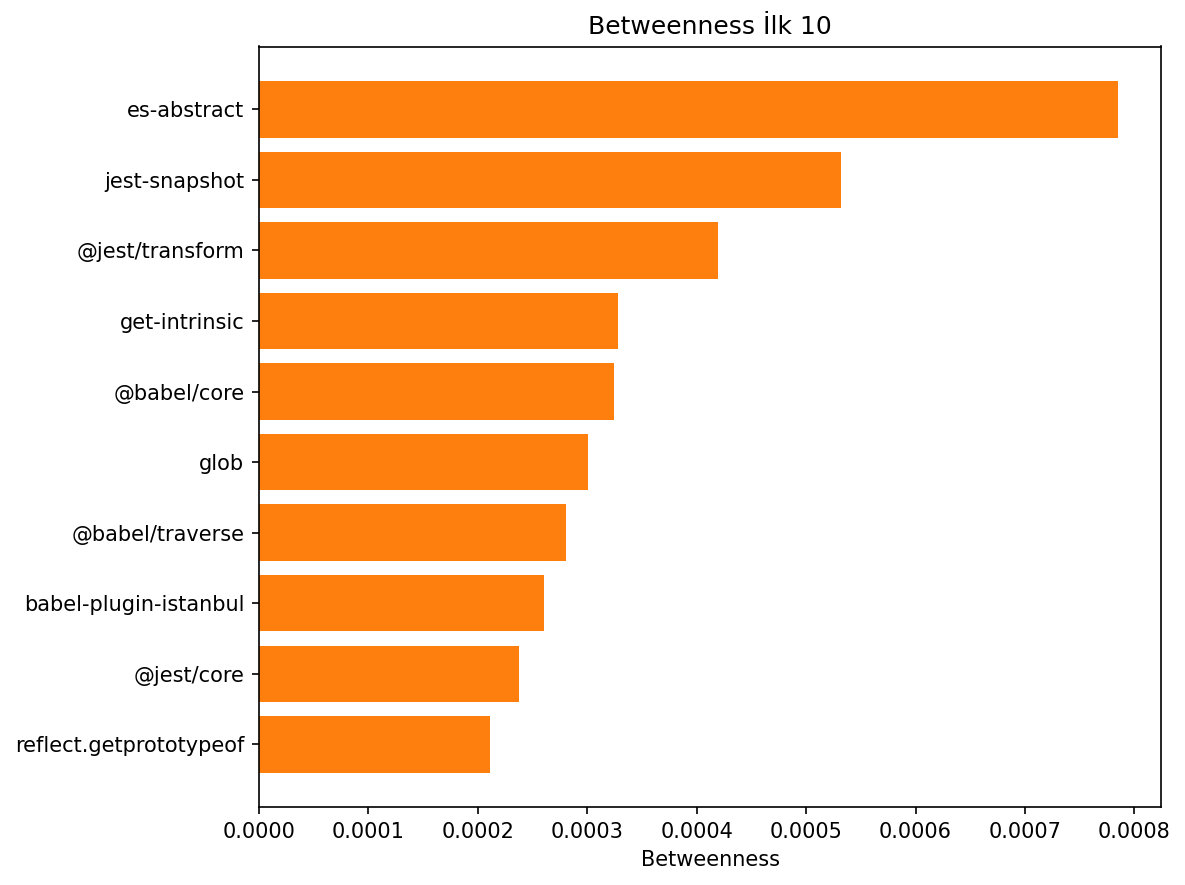

In [50]:
try:
    import matplotlib.pyplot as plt
    # In-Degree ilk 10 (tüm düğümler)
    top10_in = sorted(in_deg.items(), key=lambda kv: kv[1], reverse=True)[:10]
    names_in = [n for n,_ in top10_in][::-1]
    vals_in = [v for _,v in top10_in][::-1]

    # Out-Degree ilk 10 (tüm düğümler)
    top10_out = sorted(out_deg.items(), key=lambda kv: kv[1], reverse=True)[:10]
    names_out = [n for n,_ in top10_out][::-1]
    vals_out = [v for _,v in top10_out][::-1]

    # Betweenness ilk 10 (tüm düğümler)
    top10_btw = sorted(btw.items(), key=lambda kv: kv[1], reverse=True)[:10]
    names_btw = [n for n,_ in top10_btw][::-1]
    vals_btw = [v for _,v in top10_btw][::-1]

    fig, axes = plt.subplots(1, 3, figsize=(20, 6), dpi=150)
    # In-Degree grafiği
    axes[0].barh(names_in, vals_in, color='tab:blue')
    axes[0].set_title('In-Degree İlk 10')
    axes[0].set_xlabel('In-Degree')
    axes[0].tick_params(axis='y', labelsize=8)

    # Out-Degree grafiği
    axes[1].barh(names_out, vals_out, color='tab:green')
    axes[1].set_title('Out-Degree İlk 10')
    axes[1].set_xlabel('Out-Degree')
    axes[1].tick_params(axis='y', labelsize=8)

    # Betweenness grafiği
    axes[2].barh(names_btw, vals_btw, color='tab:orange')
    axes[2].set_title('Betweenness İlk 10')
    axes[2].set_xlabel('Betweenness')
    axes[2].tick_params(axis='y', labelsize=8)

    plt.tight_layout()
    out_combo = OUTDIR / 'top10_leaders.png'
    out_combo_svg = OUTDIR / 'top10_leaders.svg'
    plt.savefig(out_combo)
    plt.savefig(out_combo_svg)
    print(out_combo)

    # Ayrı ayrı da kaydedelim
    plt.figure(figsize=(8,6), dpi=150); plt.barh(names_in, vals_in, color='tab:blue'); plt.title('In-Degree İlk 10'); plt.xlabel('In-Degree'); plt.tight_layout(); plt.savefig(OUTDIR / 'top10_in_degree.png')
    plt.savefig(OUTDIR / 'top10_in_degree.svg')
    plt.figure(figsize=(8,6), dpi=150); plt.barh(names_out, vals_out, color='tab:green'); plt.title('Out-Degree İlk 10'); plt.xlabel('Out-Degree'); plt.tight_layout(); plt.savefig(OUTDIR / 'top10_out_degree.png')
    plt.savefig(OUTDIR / 'top10_out_degree.svg')
    plt.figure(figsize=(8,6), dpi=150); plt.barh(names_btw, vals_btw, color='tab:orange'); plt.title('Betweenness İlk 10'); plt.xlabel('Betweenness'); plt.tight_layout(); plt.savefig(OUTDIR / 'top10_betweenness.png')
    plt.savefig(OUTDIR / 'top10_betweenness.svg')
except ModuleNotFoundError:
    print('matplotlib bulunamadı; görselleştirme atlandı.')

## 10) Derece Dağılımları (Histogram)

In-degree ve out-degree dağılımlarını inceleyelim (log ölçek).

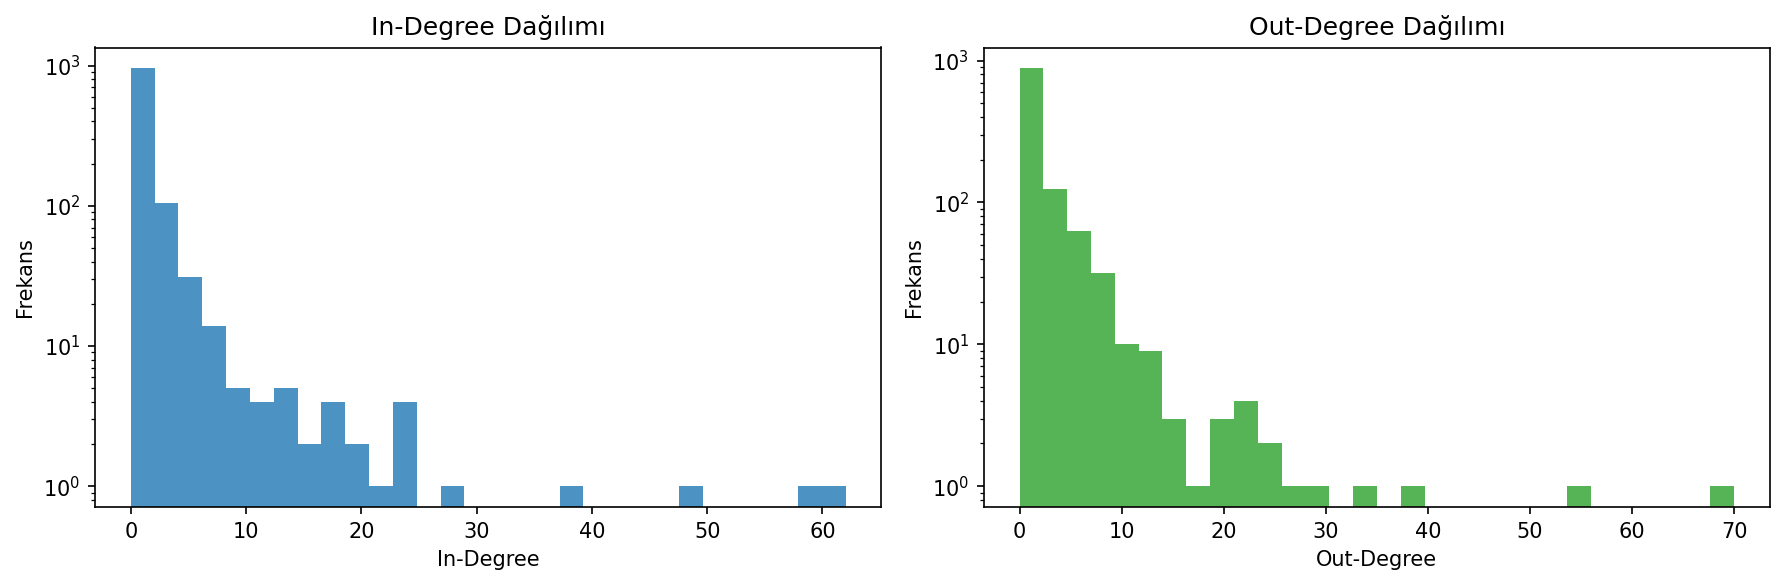

In [51]:
try:
    import matplotlib.pyplot as plt
    import numpy as np
    indeg_vals = np.array(list(in_deg.values()))
    outdeg_vals = np.array(list(out_deg.values()))
    fig, ax = plt.subplots(1,2, figsize=(12,4), dpi=150)
    ax[0].hist(indeg_vals, bins=30, color='tab:blue', alpha=0.8)
    ax[0].set_title('In-Degree Dağılımı'); ax[0].set_yscale('log')
    ax[0].set_xlabel('In-Degree'); ax[0].set_ylabel('Frekans')
    ax[1].hist(outdeg_vals, bins=30, color='tab:green', alpha=0.8)
    ax[1].set_title('Out-Degree Dağılımı'); ax[1].set_yscale('log')
    ax[1].set_xlabel('Out-Degree'); ax[1].set_ylabel('Frekans')
    plt.tight_layout()
    plt.savefig(OUTDIR / 'degree_histograms.png')
    plt.savefig(OUTDIR / 'degree_histograms.svg')
except ModuleNotFoundError:
    print('matplotlib bulunamadı; görselleştirme atlandı.')

## 11) Korelasyonlar (Dağılım Grafikleri)

In-degree vs Betweenness ve In-degree vs Out-degree.

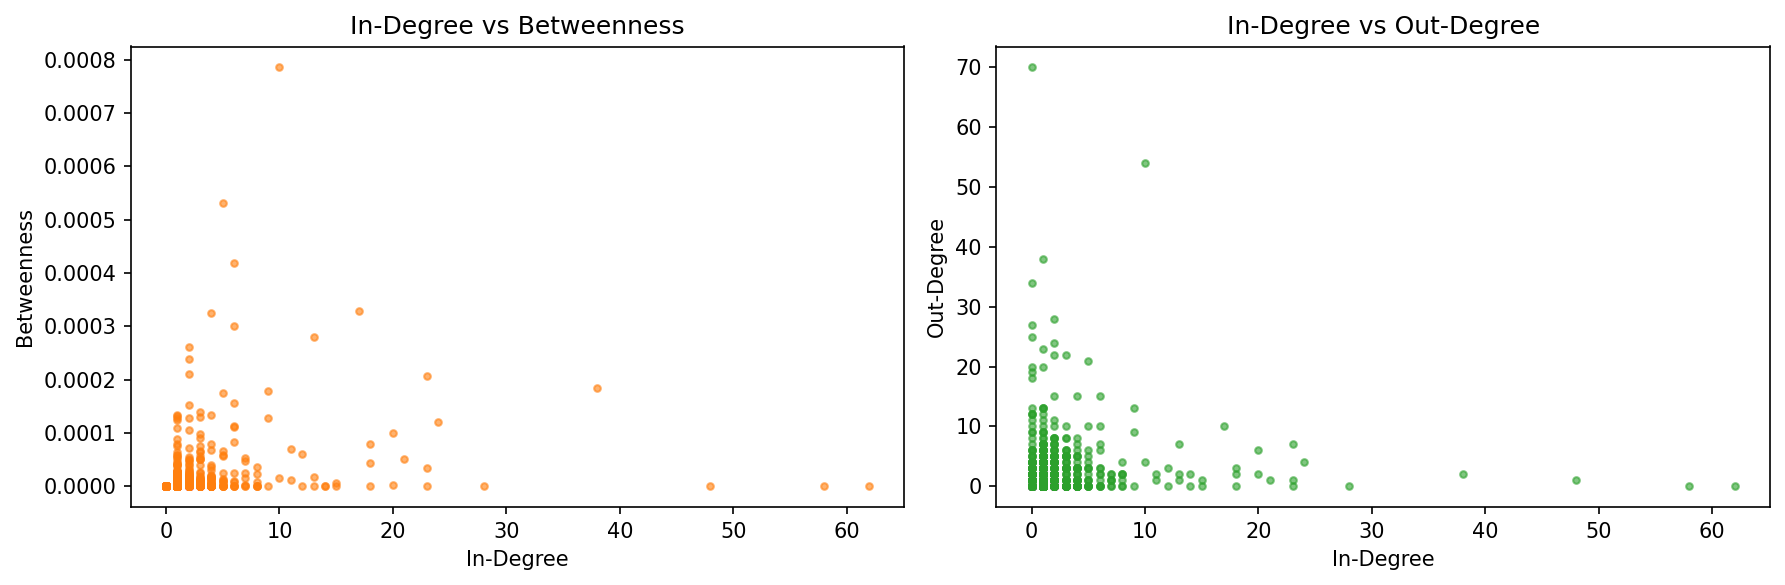

In [52]:
try:
    import matplotlib.pyplot as plt
    import numpy as np
    nodes_list = list(G.nodes())
    x_in = np.array([in_deg.get(n,0) for n in nodes_list])
    y_btw = np.array([btw.get(n,0.0) for n in nodes_list])
    y_out = np.array([out_deg.get(n,0) for n in nodes_list])
    fig, ax = plt.subplots(1,2, figsize=(12,4), dpi=150)
    ax[0].scatter(x_in, y_btw, s=10, alpha=0.6, color='tab:orange')
    ax[0].set_title('In-Degree vs Betweenness')
    ax[0].set_xlabel('In-Degree'); ax[0].set_ylabel('Betweenness')
    ax[1].scatter(x_in, y_out, s=10, alpha=0.6, color='tab:green')
    ax[1].set_title('In-Degree vs Out-Degree')
    ax[1].set_xlabel('In-Degree'); ax[1].set_ylabel('Out-Degree')
    plt.tight_layout()
    plt.savefig(OUTDIR / 'scatter_correlations.png')
    plt.savefig(OUTDIR / 'scatter_correlations.svg')
except ModuleNotFoundError:
    print('matplotlib bulunamadı; görselleştirme atlandı.')

## 12) Bağlanırlık ve Bileşenler

Zayıf bağlanırlık bileşenleri ve temel ağ istatistikleri.

In [53]:
import json
import networkx as nx
W = G.to_undirected()
components = list(nx.connected_components(W))
components_sizes = sorted([len(c) for c in components], reverse=True)
stats = {
    'nodes': G.number_of_nodes(),
    'edges': G.number_of_edges(),
    'components_count': len(components),
    'largest_component_size': components_sizes[0] if components_sizes else 0,
    'avg_in_degree': (sum(in_deg.values())/len(in_deg)) if in_deg else 0,
    'avg_out_degree': (sum(out_deg.values())/len(out_deg)) if out_deg else 0,
}
(OUTDIR / 'graph_stats.json').write_text(json.dumps(stats, ensure_ascii=False, indent=2), encoding='utf-8')
stats

{'nodes': 1139,
 'edges': 2164,
 'components_count': 160,
 'largest_component_size': 853,
 'avg_in_degree': 1.8999122036874452,
 'avg_out_degree': 1.8999122036874452}

## 13) Köprü Kenarlar (Edge Betweenness)

En yüksek edge betweenness değerine sahip 10 kenarı çıkaralım.

In [54]:
import csv
import networkx as nx
eb = nx.edge_betweenness_centrality(G, normalized=True)
top_edges = sorted(eb.items(), key=lambda kv: kv[1], reverse=True)[:10]
with (OUTDIR / 'edge_betweenness_top10.csv').open('w', newline='', encoding='utf-8') as f:
    w = csv.writer(f); w.writerow(['u','v','edge_betweenness'])
    [w.writerow([u,v, f'{val:.6f}']) for (u,v), val in top_edges]
top_edges

[(('@jest/transform', 'babel-plugin-istanbul'), 0.0002222553108539799),
 (('@jest/expect', 'jest-snapshot'), 0.0002120329809651217),
 (('jest-snapshot', '@jest/transform'), 0.00020575814198931945),
 (('jest', '@jest/core'), 0.00015001751297271526),
 (('call-bound', 'get-intrinsic'), 0.00014950593725410844),
 (('glob', 'jackspeak'), 0.0001473558497186352),
 (('reflect.getprototypeof', 'which-builtin-type'), 0.00014609573861283884),
 (('jackspeak', '@isaacs/cliui'), 0.00013964088376477996),
 (('babel-plugin-istanbul', 'test-exclude'), 0.0001392551354670872),
 (('@babel/core', '@babel/helper-compilation-targets'),
  0.00013848363887170167)]